In [2]:
import keras
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [3]:
import pandas as pd
import cv2 as cv
import numpy as np
import chainer.optimizers as O

In [13]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [14]:
train_set = torchvision.datasets.FashionMNIST(root = ".", train = True , 
                                              download = True , transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train = False , 
                                             download = True , transform = transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(train_set , batch_size = 5, 
                                              shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set , batch_size = 5, 
                                          shuffle = False)
torch.manual_seed(0)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.is_available()
# device

Building a method that return the name of class for the label number. For example if the label is 5, we return Sandal.

In [17]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

 Visualization of Data using matplotlib imshow()

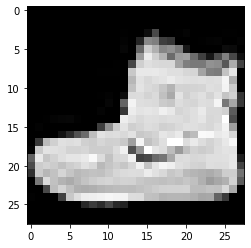

In [71]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, 

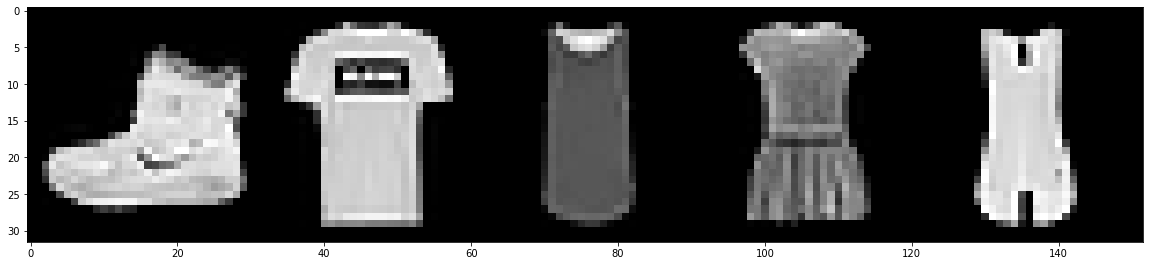

In [23]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

# Building a CNN

Make a model class (FashionCNN in our case)
It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
Our Neural Net has following layers:

Two Sequential layers each consists of following layers-

Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one.

Stride of 1 in both layer.

Batch Normalization layer.

Acitvation function: ReLU.

Max Pooling layer with kernel size of 2 * 2 and stride 2.

Flatten out the output for dense layer(a.k.a. fully connected layer).

3 Fully connected layer with different in/out features.

1 Dropout layer that has class probability p = 0.25.

All the functionaltiy is given in forward method that defines the forward pass of CNN.

Our input image is changing in a following way:

First Convulation layer : input: 28 * 28 * 3, output: 28 * 28 * 32
First Max Pooling layer : input: 28 * 28 * 32, output: 14 * 14 * 32
Second Conv layer : input : 14 * 14 * 32, output: 12 * 12 * 64
Second Max Pooling layer : 12 * 12 * 64, output: 6 * 6 * 64
Final fully connected layer has 10 output features for 10 types of clothes.

In [24]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        self.drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.pool1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.pool2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        
        return out


# Making a model of our CNN class.

Creating a object.

Transfering it into GPU if available.

Defining a Loss function. we're using CrossEntropyLoss() here.

Using Adam algorithm for optimization purpose.

In [25]:
model = FashionCNN()
model.to(device)
error = nn.CrossEntropyLoss()  # Loss_Function
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)

def weights_init(self):
    for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            print(layer)
            
model.apply(weights_init)

print(model)

Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=1024, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)
Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=1024, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)
FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


# Train the model for epochs = 50

In [32]:
#training loop
losses = []

num_epochs = 50
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

for i in range(num_epochs):
    correct = 0
    total = 0
    for images,labels in training_loader:
        
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images)
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        predictions = torch.max(outputs, 1)[1].to(device)
        correct += (predictions == labels).sum()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len(labels)
        count += 1
        
    accuracy = correct * 100 / total
#     print(loss)
    losses.append(loss.data)
    accuracy_list.append(accuracy)
    iteration_list.append(count)

In [72]:
print(accuracy)
print(accuracy_list)
print(iteration_list)

tensor(81.2736)
[tensor(81.5200), tensor(81.3950), tensor(81.3567), tensor(81.3650), tensor(81.3540), tensor(81.3167), tensor(81.2986), tensor(81.3037), tensor(81.3100), tensor(81.3000), tensor(81.3200), tensor(81.3142), tensor(81.3054), tensor(81.3050), tensor(81.3180), tensor(81.3075), tensor(81.3129), tensor(81.3083), tensor(81.2963), tensor(81.2965), tensor(81.3000), tensor(81.2936), tensor(81.2922), tensor(81.2858), tensor(81.2972), tensor(81.2719), tensor(81.2722), tensor(81.2714), tensor(81.2721), tensor(81.2823), tensor(81.2790), tensor(81.2881), tensor(81.2794), tensor(81.2779), tensor(81.2871), tensor(81.2875), tensor(81.2835), tensor(81.2739), tensor(81.2690), tensor(81.2740), tensor(81.2727), tensor(81.2764), tensor(81.2712), tensor(81.2743), tensor(81.2687), tensor(81.2620), tensor(81.2634), tensor(81.2654), tensor(81.2651), tensor(81.2736)]
[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 400

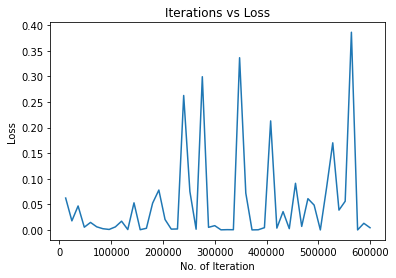

In [39]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

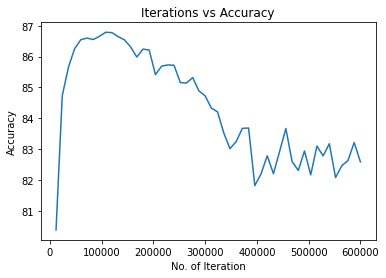

In [36]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

# Test the model for Accuracy

In [66]:
total = 0
correct = 0
count=0
loss_list = []
iteration_list = []
accuracy_list = []
num_epochs = 50
# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []
#accuracy of the model
for i in range(num_epochs):
    for images, labels in test_loader:

        x_test, y_test = images.to(device), labels.to(device)
        labels_list.append(y_test)       
        x_test = Variable(x_test)
        y_pred = model(x_test)
        predictions = torch.max(y_pred, 1)[1].to(device)
        predictions_list.append(predictions)
        loss = error(y_pred, y_test)

        correct += (predictions == y_test).sum()
        total += len(labels)
        count = count+1
        
    accuracy = correct * 100 / total
    loss_list.append(loss.data)
    iteration_list.append(count)  
    accuracy_list.append(accuracy)
    
print("Accuracy is : ",accuracy)


Accuracy is :  tensor(81.2736)


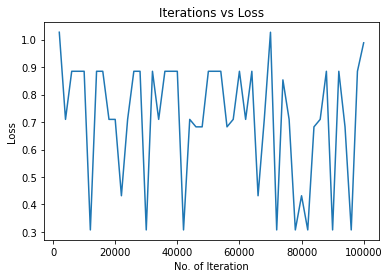

In [67]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

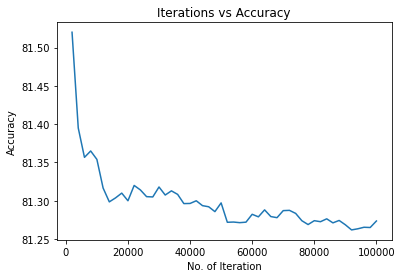

In [68]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

# Classification Accuracy

In [73]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [74]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     50000
           1       0.98      0.97      0.98     50000
           2       0.72      0.60      0.66     50000
           3       0.89      0.81      0.85     50000
           4       0.50      0.75      0.60     50000
           5       0.97      0.95      0.96     50000
           6       0.56      0.44      0.49     50000
           7       0.93      0.94      0.94     50000
           8       0.95      0.96      0.96     50000
           9       0.96      0.94      0.95     50000

    accuracy                           0.81    500000
   macro avg       0.82      0.81      0.81    500000
weighted avg       0.82      0.81      0.81    500000


